# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors


/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [4]:
adata = sc.read('/home/olavdc/github/linearSCVI_experiments/data/pijuan_sala_atlas.h5ad')

In [5]:
idx = adata.obs.query('not doublet').index
# idx = np.random.choice(idx, 20000, replace=False)
adata = adata[idx]

In [6]:
adata.X.getnnz() / (adata.X.shape[0] * adata.X.shape[1])

0.1144419646406324

In [7]:
adata

View of AnnData object with n_obs × n_vars = 125775 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'

In [8]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")

/tmp/ipykernel_10910/1290875701.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()  # preserve counts


In [9]:
adata.layers["counts"]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 21430390 stored elements and shape (125775, 1000)>

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [10]:
# setup the anndata for scvi-tools
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")

In [11]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(
    adata,
    use_batch_norm=True,
    gene_likelihood = "nb",
    n_latent=20)

In [12]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="linearSCVI-tests")

In [13]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(
    max_epochs= 100, 
    plan_kwargs={"lr": 7e-3},
    logger = wandb_logger,
    early_stopping_monitor ='reconstruction_loss_validation',
    early_stopping_patience= 50,
    check_val_every_n_epoch = 1
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: olav-declerck (deeplife) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [11:43<00:00,  7.03s/it, v_num=hjtn, train_loss_step=468, train_loss_epoch=493]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [11:43<00:00,  7.04s/it, v_num=hjtn, train_loss_step=468, train_loss_epoch=493]


In [14]:
model.history

Load Z & W

Inspecting the convergence

In [15]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z
Z_df = pd.DataFrame(Z_hat, adata.obs.index)
Z_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,,,,,,,,,,,,,,,,,,,,
cell_1,-1.192471,0.658295,-0.921776,1.246097,0.986578,1.196681,-0.019817,-0.089928,0.600102,0.080940,-0.095056,1.009604,1.015258,-1.005906,-0.825051,-1.005264,-1.175871,-0.233304,-1.300815,-0.133127
cell_2,0.131179,0.120108,-0.532644,0.546901,1.555186,0.796974,0.638921,-0.458201,0.049254,-1.108398,-0.600963,1.081085,-0.134275,-1.190696,-0.430685,-0.426853,-1.045545,-1.025536,0.448215,-0.582892
cell_3,-1.964361,-0.310125,-4.300760,-0.074515,-1.033482,-0.692434,-0.624926,1.479411,-1.744061,-0.652900,1.034414,1.158868,-1.210640,1.355215,-0.062885,0.650287,0.303240,-2.124628,1.697817,-0.671229
cell_4,-2.722635,0.271662,-1.643237,1.042550,1.346920,0.533905,0.741932,-0.282883,-0.693412,1.074929,-0.436694,1.798059,-0.706013,-2.103984,0.261848,0.246140,-1.147785,-1.039277,0.294180,0.852453
cell_5,-1.701760,-1.403925,-0.478755,-1.805519,0.509082,-0.796035,-0.666810,1.013351,0.017280,0.285322,0.759171,-1.611512,-0.492945,0.210556,-2.458206,0.428537,-1.539001,0.336437,0.312752,0.413416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_139327,-0.338838,-2.058176,1.206318,0.446922,-1.911180,-1.861787,-2.209160,-1.542732,0.301730,-0.370604,-0.409773,2.478986,-0.372429,1.001562,-0.404780,1.232610,-0.069445,2.091180,-0.631445,-0.242398
cell_139328,-0.071387,-1.168657,-0.822929,-0.190927,-0.337849,-1.098302,-0.415855,0.791471,0.361234,0.516940,-1.965575,-0.433834,-1.095331,0.257245,2.048025,0.951275,-1.228601,1.118621,-0.069852,0.799588
cell_139329,-0.508008,-0.052256,1.304928,-0.671892,-0.033521,-1.991939,0.929081,-0.093908,1.797618,1.204471,1.035188,0.018341,0.960802,0.543185,2.180172,2.337973,0.284599,-0.061657,-0.436818,0.790356


In [16]:
W_df = model.get_loadings()
W_df.index = adata.var.gene_name.values
W_df

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19
Sox17,0.036305,0.544487,-0.824041,-0.015258,-0.130507,0.955959,0.759527,-0.404149,-0.217154,-0.027617,-0.477186,0.350247,-0.165373,-0.137005,0.040009,0.101467,-0.381057,-0.490428,0.580868,-0.535961
Tfap2b,0.744225,0.316597,-0.512157,0.311698,0.605608,-0.311909,-0.332014,0.341681,0.679308,0.443840,-0.782847,-0.348484,-0.302768,-0.938638,0.598389,-0.046300,-0.569131,1.373407,-0.581339,0.708844
Cfc1,0.030704,0.443042,0.058976,0.831810,0.629225,0.412340,-0.308911,-0.171389,-0.048652,-0.134894,-0.146622,0.648073,0.042962,-0.113346,0.103408,-0.234980,0.022009,-1.293349,0.085169,-0.213896
Col3a1,-0.081437,0.383467,-0.053442,0.522197,-0.334218,0.143747,-0.138958,-0.549341,0.968369,-0.309005,-0.108784,0.008288,0.261279,-0.760532,1.184384,-0.235977,-0.470182,-0.001882,-0.932288,0.139553
Sdpr,-0.171219,0.183989,-0.382061,0.562511,0.395759,0.213518,-0.408441,-0.563033,0.129766,-0.086397,-0.090581,-0.437193,0.139314,-0.198386,0.515930,-0.564577,0.245548,0.261758,-0.722597,0.353763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm28578,0.057430,0.188656,-0.076740,0.270957,0.606645,0.343892,0.342682,-0.208274,0.290565,-0.100262,-0.152263,0.280911,-0.058637,-0.641230,0.035198,-0.770349,-0.583251,-0.089263,-0.385363,0.015083
Fgf8,-0.338879,0.364454,-0.423760,0.395175,1.203394,-0.341319,1.199406,-1.001502,0.122668,-0.491682,-0.465413,0.975622,-0.389545,-0.392480,0.523881,-0.220342,-0.385099,-0.697438,-0.196255,-0.408398
Gsto1,-0.281950,-0.022921,-0.041980,0.095395,0.547667,0.247418,0.318967,0.267830,0.119225,0.075775,-0.159091,0.378263,-0.067906,-0.352323,-0.387372,-0.410206,-0.468289,0.105975,-0.273413,0.138418
mt-Co1,0.157267,0.104900,0.213261,0.364391,0.326790,0.395092,0.473595,-0.341185,0.137906,0.001437,-0.187855,0.364201,0.079191,-0.371651,-0.361816,-0.512184,-0.264110,-0.122519,-0.443195,0.027384


In [49]:
Z_df = pd.read_csv("Z_df.csv" , index_col=0)
W_df = pd.read_csv("W_df.csv", index_col=0)

In [50]:
Z_df = Z_df.add_prefix('z')
# W_df = W_df.add_prefix('z')

In [51]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [52]:
_, variance_explained = Z_covariance(Z_df)
idx = np.argsort(variance_explained)[::-1]

In [53]:
variance_explained

array([0.00575523, 0.07089547, 0.04009096, 0.06067754, 0.0598001 ,
       0.05803454, 0.04353043, 0.05631585, 0.04541507, 0.04642414,
       0.05478382, 0.05442635, 0.05350253, 0.05296373, 0.05226941,
       0.04726909, 0.04830079, 0.04897299, 0.05007034, 0.05050162])

In [54]:
Z_df_ordered = pd.DataFrame(Z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = Z_df.index
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = W_df.index

In [55]:
text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}

In [56]:
W_df_ordered["gene_name"] = W_df_ordered.index

In [57]:
W_df_ordered

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,gene_name
Sox17,-0.246410,-0.045092,-0.287151,-0.789523,-1.045076,0.379745,-0.274546,0.196310,-0.240720,0.120630,...,1.304814,0.896123,0.977160,0.140709,0.507350,0.371004,0.671410,0.122417,-0.272740,Sox17
Tfap2b,-0.866101,0.264635,0.441139,0.316459,0.241662,0.724576,0.524609,-0.267029,-0.603369,-3.058189,...,2.695934,-2.704998,-0.379437,0.121184,2.034993,-1.189720,0.231029,-1.043175,-0.200031,Tfap2b
Cfc1,0.624126,0.013253,-0.368559,0.049087,-0.617492,-0.296434,-0.349046,0.162514,-0.108412,-0.709184,...,0.656069,0.857923,0.987424,-0.300895,0.407504,0.021973,-0.031557,0.088493,-0.347714,Cfc1
Col3a1,0.892152,0.584841,0.221267,-0.142747,0.467602,0.326911,0.113969,-0.206771,0.262682,-2.660484,...,2.447797,-1.991427,1.220442,0.736977,1.186071,-0.417802,-0.202325,0.194393,0.110537,Col3a1
Sdpr,0.032270,0.235480,0.369317,0.430961,-0.138376,-0.660213,-0.032299,0.114108,0.219400,-2.127024,...,1.926121,-1.298408,0.456596,0.735391,1.986155,0.079298,-0.236254,-0.245711,-0.010300,Sdpr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm28578,0.162844,0.162418,-0.133726,-0.087193,0.467282,-0.058443,-0.226556,-0.052540,0.189532,-1.927879,...,2.668600,-0.088382,-0.272573,0.271625,0.924744,-0.362568,0.278767,-0.072720,0.439119,Gm28578
Fgf8,1.151633,-0.118610,0.155103,-0.391869,-0.098779,0.132863,0.028003,0.371833,0.178274,-1.705620,...,0.372218,1.086067,0.321909,-0.560324,-0.967330,0.581501,0.727361,-0.022856,-0.184798,Fgf8
Gsto1,-0.035420,0.107007,-0.095236,-0.081038,0.276695,-0.103528,-0.064666,-0.148735,-0.083487,0.592641,...,-1.160491,0.200679,-0.708745,-0.220518,0.003942,-0.183609,-0.017694,-0.001433,-0.087499,Gsto1
mt-Co1,0.214536,0.035590,-0.119251,-0.057384,-0.053980,-0.019141,-0.066441,0.002488,-0.041561,0.621536,...,-1.962248,0.408455,-0.165785,-0.056202,-0.729712,0.009136,-0.075404,-0.186592,0.568975,mt-Co1


['Pax1' 'Gsc' 'AC153379.1' 'Saa2' 'Lum' 'Prl2a1' 'C5ar1' 'Fgf8']
['Olig2' 'Phox2b' 'Lefty1' 'Pax1' 'Neurod4' 'Cer1' 'Ctxn3' 'Nkx2-1']
['Msx3' 'Dcpp1' 'Samd3' 'Dcpp3' 'Tekt4' 'Hes3' 'Cer1' 'Foxd4']
['Car1' 'Foxd4' 'Shh' 'Serpina1b' 'Nkx2-6' 'Six6' 'Hes3' 'Klhl6']


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


['AC153379.1' 'Emcn' 'Cxcl13' 'Cryaa' 'Foxd4' 'Bglap2' 'Dbx1' 'Fezf1']


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


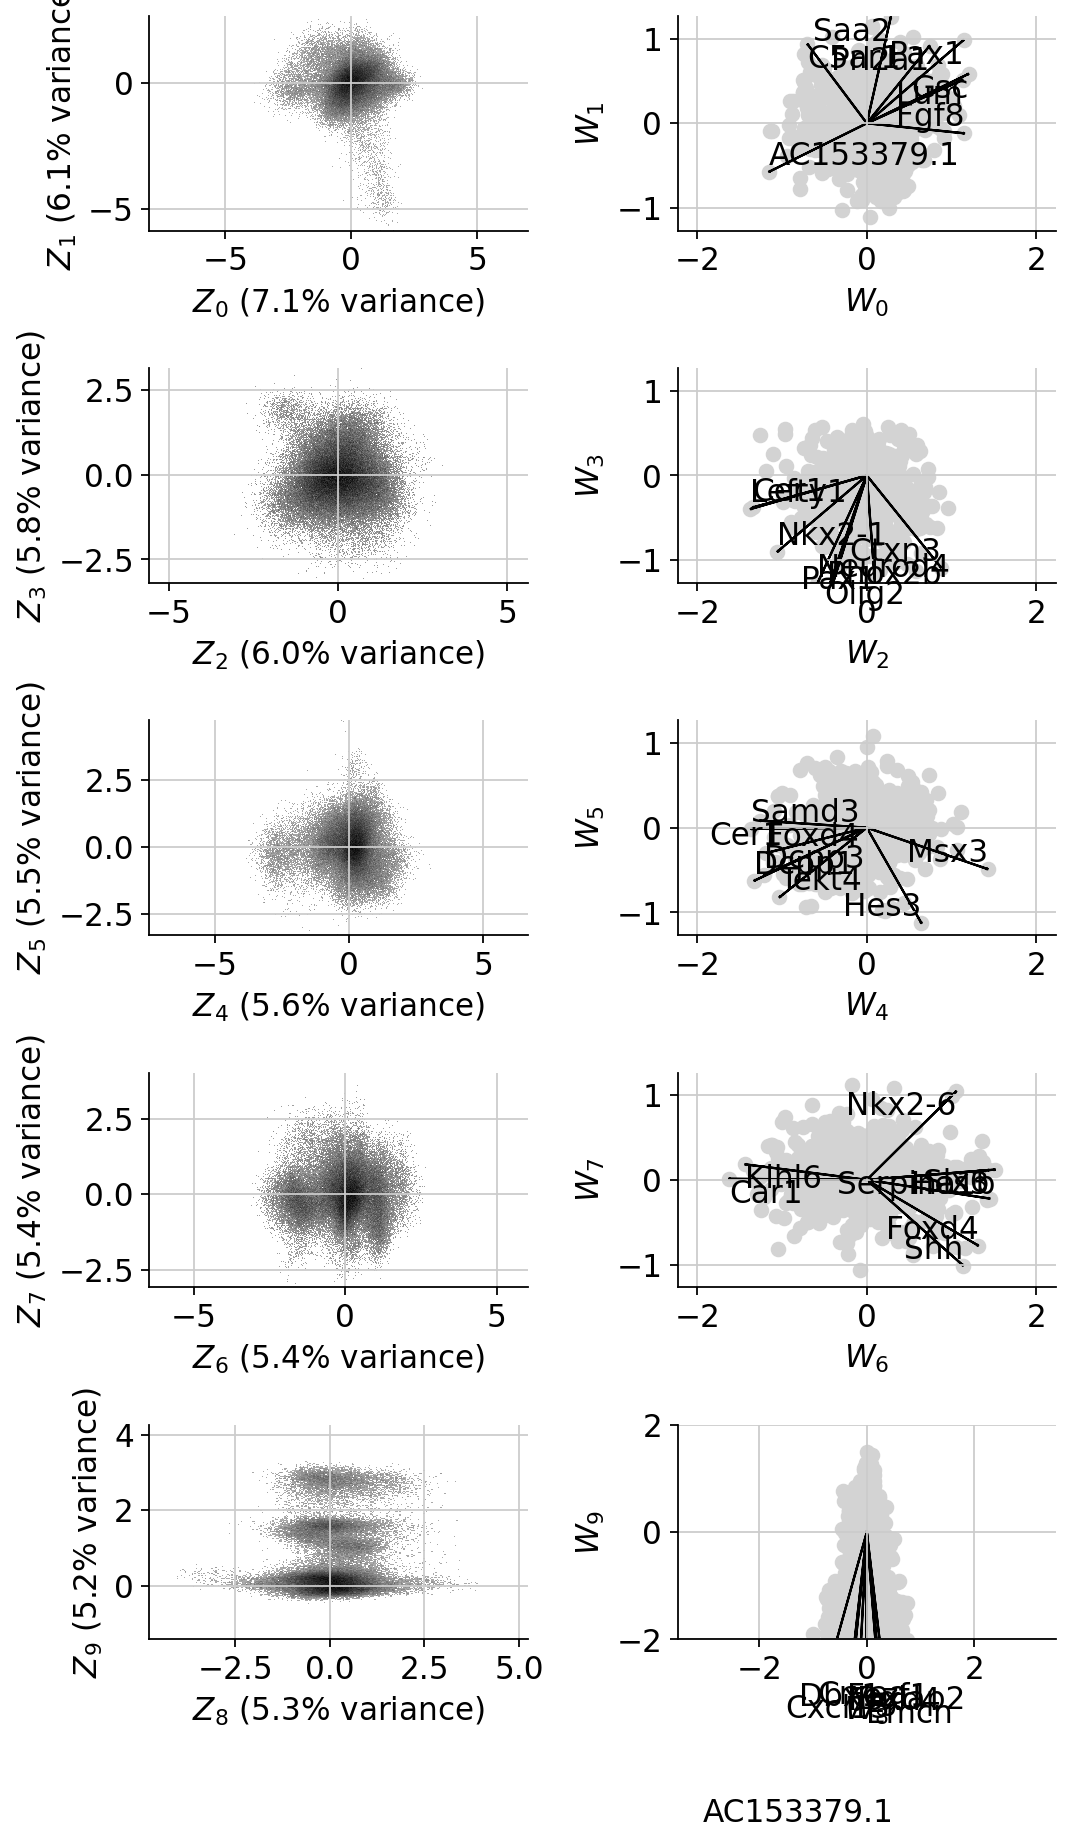

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define figure size
plt.figure(figsize=(7, 12))

# Iterate for each plot
for i in range(5):
    
    # -- Z plot --
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right' if x_ > 0 else 'left'
        va = 'top' if y_ > 0 else 'bottom'
        
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='black'))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-2, right=2)
    plt.ylim(bottom=-2, top=2)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to fit plots
plt.tight_layout()

# Save figure as a PDF with high resolution
# plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)


In [59]:
adata = sc.read('/home/olavdc/github/linearSCVI_experiments/data/pijuan_sala_atlas.h5ad')

In [60]:
metadata = adata.obs.loc[Z_df_ordered.index]

In [61]:
metadata

,barcode,sample,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,...,haem_gephiY,haem_subclust,endo_gephiX,endo_gephiY,endo_trajectoryName,endo_trajectoryDPT,endo_gutX,endo_gutY,endo_gutDPT,endo_gutCluster
index,,,,,,,,,,,,,,,,,,,,,
cell_1,AAAGGCCTCCACAA,1,E6.5,1,TS9,0.043114,False,2.0,4.0,2.0,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_2,AACAAACTCGCCTT,1,E6.5,1,TS9,1.129713,False,12.0,1.0,1.0,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_3,AACAATACCCGTAA,1,E6.5,1,TS9,0.000000,False,NaN,NaN,NaN,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_4,AACACTCTCATTCT,1,E6.5,1,TS9,0.084689,False,NaN,NaN,NaN,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_5,AACAGAGAATCAGC,1,E6.5,1,TS9,0.112121,False,3.0,7.0,4.0,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_139327,TTTCGAACTAACCG,37,E8.5,3,TS12,0.303505,False,18.0,2.0,19.0,...,17055.58,Ery4,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_139328,TTTCTACTCATACG,37,E8.5,3,TS12,0.000000,False,NaN,NaN,NaN,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan
cell_139329,TTTCTACTGGGATG,37,E8.5,3,TS12,0.344835,False,13.0,2.0,18.0,...,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan


In [62]:
metadata = metadata.join(Z_df_ordered)

In [63]:
metadata.head().T

index,cell_1,cell_2,cell_3,cell_4,cell_5
barcode,AAAGGCCTCCACAA,AACAAACTCGCCTT,AACAATACCCGTAA,AACACTCTCATTCT,AACAGAGAATCAGC
sample,1,1,1,1,1
stage,E6.5,E6.5,E6.5,E6.5,E6.5
sequencing.batch,1,1,1,1,1
theiler,TS9,TS9,TS9,TS9,TS9
doub.density,0.043114,1.129713,0.0,0.084689,0.112121
doublet,False,False,False,False,False
cluster,2.0,12.0,NaN,NaN,3.0
cluster.sub,4.0,1.0,NaN,NaN,7.0
cluster.stage,2.0,1.0,NaN,NaN,4.0


In [64]:
for ctype in np.unique(metadata['celltype']):
    z_corrs = Z_df_ordered.corrwith((metadata['celltype'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head()
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

[' z8: -0.24', 'z10: -0.21', 'z11: -0.19', 'z18: +0.18', 'z15: +0.16'] Allantois
[' z4: -0.22', 'z12: +0.14', ' z0: +0.12', ' z3: -0.10', ' z6: -0.08'] Anterior Primitive Streak
[' z0: -0.23', ' z6: -0.14', 'z14: +0.09', ' z4: -0.09', 'z10: +0.07'] Blood progenitors 1
[' z0: -0.38', ' z6: -0.25', 'z12: -0.21', ' z4: -0.16', ' z2: -0.11'] Blood progenitors 2
[' z1: -0.43', 'z18: +0.22', ' z5: -0.18', ' z3: -0.15', 'z14: +0.14'] Cardiomyocytes
['z16: +0.21', 'z14: -0.17', ' z2: +0.07', 'z18: -0.07', ' z9: -0.06'] Caudal Mesoderm
['z16: +0.24', ' z5: -0.21', 'z14: -0.17', ' z3: +0.12', 'z18: -0.11'] Caudal epiblast
[' z5: -0.14', ' z3: +0.13', ' z6: +0.09', ' z4: +0.08', ' z7: +0.07'] Caudal neurectoderm
[' z4: -0.26', ' z3: -0.09', ' z0: +0.08', 'z12: +0.07', ' z8: -0.07'] Def. endoderm
['z10: +0.27', 'z14: +0.26', ' z7: +0.23', ' z0: -0.14', ' z2: +0.12'] Endothelium
['z15: -0.46', 'z13: -0.37', 'z12: +0.37', 'z11: +0.29', 'z14: +0.28'] Epiblast
['z12: -0.36', ' z6: -0.22', 'z15: -0.15'

In [33]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f

In [34]:
from matplotlib import cm
from scipy import stats


In [69]:
vardata = W_df_ordered

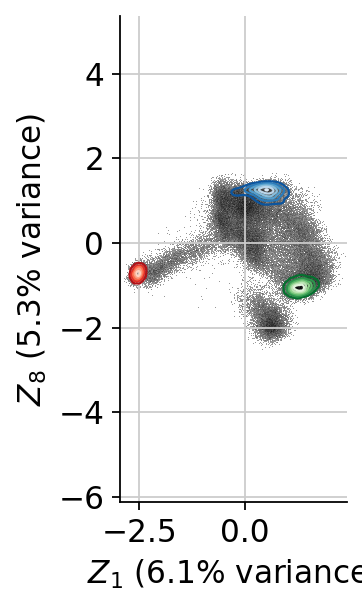

In [66]:
plt.subplot(1, 2, 1)

plt.hist2d(
    Z_df_ordered[f'z12'], Z_df_ordered[f'z13'],
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=cm.gray_r,
    rasterized=True
)

plt.axis('equal')
plt.xlabel('$Z_1$ ' + f'({variance_explained[idx][1]:.1%} variance)')
plt.ylabel('$Z_{8}$ ' + f'({variance_explained[idx][8]:.1%} variance)')

ax = plt.gca()

color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
cell_types = ['Erythroid3', 'ExE endoderm', 'Epiblast']
for color, ctype in zip(color_maps, cell_types):
    X = metadata.query('celltype == @ctype')[['z12', 'z13']]
    xx1, xx2, f = make_kde(X['z12'], X['z13'])
    cset = ax.contour(
        xx1,
        xx2,
        f,
        levels=6,
        cmap=color,
        linewidths=1.
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered['w9'], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[['w9', 'w12']].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[['w9', 'w12']].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[['w9', 'w12']].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel('$W_{9}$')
# plt.ylabel('$W_{12}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

In [71]:
vardata.sort_values('w12', ascending=False)[['w12', 'gene_name']].tail(10)

,w12,gene_name
Nxpe2,-3.029169,Nxpe2
Slc4a1,-3.098935,Slc4a1
Hba-x,-3.156897,Hba-x
Hsd3b6,-3.458058,Hsd3b6
Hba-a1,-3.475345,Hba-a1
Hba-a2,-3.511914,Hba-a2
Csf2rb,-3.607528,Csf2rb
Hbb-y,-3.721686,Hbb-y
Hbb-bs,-3.758219,Hbb-bs
Hbb-bt,-3.830235,Hbb-bt


In [72]:
vardata.sort_values('w13', ascending=False)[['w13', 'gene_name']].head(10)

,w13,gene_name
Zic1,2.769244,Zic1
Nkx2-6,1.675566,Nkx2-6
Nepn,1.548227,Nepn
Serpina1b,1.518029,Serpina1b
1700011H14Rik,1.512070,1700011H14Rik
Cck,1.421647,Cck
Hoxd4,1.416566,Hoxd4
Dlk1,1.353261,Dlk1
Arg1,1.311708,Arg1
8430408G22Rik,1.298019,8430408G22Rik


In [73]:
vardata.sort_values('w13', ascending=False)[['w13', 'gene_name']].tail(10)

,w13,gene_name
Pou3f1,-1.555482,Pou3f1
Cldn4,-1.555594,Cldn4
Ccl20,-1.571016,Ccl20
Elf5,-1.587290,Elf5
Rhox1,-1.587473,Rhox1
AA467197,-1.668868,AA467197
Prss50,-1.683057,Prss50
Nr0b1,-1.766942,Nr0b1
Dppa4,-1.853401,Dppa4
Utf1,-2.011098,Utf1


In [39]:
vardata.sort_values('w3', ascending=False)[['w3', 'gene_name']].tail(10)

,w3,gene_name
Hoxc6,-0.635940,Hoxc6
Hoxb9,-0.641430,Hoxb9
Bhlha9,-0.649800,Bhlha9
Hoxd9,-0.667456,Hoxd9
Hoxa7,-0.693543,Hoxa7
Hoxaas3,-0.695349,Hoxaas3
Hoxc8,-0.828397,Hoxc8
Hoxc9,-0.865569,Hoxc9
Hoxc10,-0.878144,Hoxc10
Hoxa9,-0.911082,Hoxa9


In [40]:
vardata.sort_values('w1', ascending=False)[['w1', 'gene_name']].tail(10)

,w1,gene_name
Vgll3,-0.456469,Vgll3
Fabp3,-0.529506,Fabp3
Gzmf,-0.532559,Gzmf
Serpinb9g,-0.547780,Serpinb9g
Ccr2,-0.553322,Ccr2
Elobl,-0.558519,Elobl
Gzme,-0.563087,Gzme
Serpinb9c,-0.565340,Serpinb9c
AA467197,-0.658468,AA467197
Cst7,-0.813830,Cst7


In [41]:
vardata.sort_values('w3', ascending=False)[['w3', 'gene_name']].tail(10)

,w3,gene_name
Hoxc6,-0.635940,Hoxc6
Hoxb9,-0.641430,Hoxb9
Bhlha9,-0.649800,Bhlha9
Hoxd9,-0.667456,Hoxd9
Hoxa7,-0.693543,Hoxa7
Hoxaas3,-0.695349,Hoxaas3
Hoxc8,-0.828397,Hoxc8
Hoxc9,-0.865569,Hoxc9
Hoxc10,-0.878144,Hoxc10
Hoxa9,-0.911082,Hoxa9


In [42]:
vardata.sort_values('w1', ascending=False)[['w1', 'gene_name']].head(10)

,w1,gene_name
Nkx2-6,1.625921,Nkx2-6
Pyy,1.317502,Pyy
Lefty2,1.287301,Lefty2
Nkx2-5,1.277876,Nkx2-5
Nepn,1.211193,Nepn
Pax8,1.194112,Pax8
Serpina1b,1.150506,Serpina1b
Nkx2-1,1.135023,Nkx2-1
Krt20,1.098950,Krt20
Vgll2,1.097725,Vgll2


In [43]:
vardata.sort_values('w3', ascending=False)[['w3', 'gene_name']].tail(10)

,w3,gene_name
Hoxc6,-0.635940,Hoxc6
Hoxb9,-0.641430,Hoxb9
Bhlha9,-0.649800,Bhlha9
Hoxd9,-0.667456,Hoxd9
Hoxa7,-0.693543,Hoxa7
Hoxaas3,-0.695349,Hoxaas3
Hoxc8,-0.828397,Hoxc8
Hoxc9,-0.865569,Hoxc9
Hoxc10,-0.878144,Hoxc10
Hoxa9,-0.911082,Hoxa9
